# Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from matplotlib import rc
import os
rc('font',**{'family':'serif','serif':['mathtime']})
rc('text', usetex=True)

`rq1_systems` defines the systems under test

In [2]:
rq1_systems = ["Husky", "AutoRally", "Fetch", "TurtleBot", "Autoware"]
rq1_systems_dict = {"husky" : "Husky", "autorally" : "AutoRally", "fetch":"Fetch", "turtlebot":"TurtleBot", "autoware":"Autoware"}
rq1_systems.sort()

In [3]:
#Generate a histogram graphic for a sequence s
def hist(s, height):
    h = s.hist(bins=50,figsize=(8,height),ylabelsize=15,xlabelsize=15, color = "black")
    h.set_frame_on(False)
    return h

In [4]:
#Generate a histogram graphic for the unknown-API-calls-percentages per node
def histUnknown(df):
    df_no_crash = df.loc[df['crashed'] == False]
    percent_unknown = df_no_crash["unknown_api_calls"] / df_no_crash["api_calls"] * 100
    return hist(percent_unknown, 3)
    

In [5]:
#Generate a histogram graphic for the non-zero unknown-API-calls-percentages per node
def histUnknownNZ(df):
    df_no_crash = df.loc[df['crashed'] == False]
    percent_unknown = df_no_crash["unknown_api_calls"] / df_no_crash["api_calls"] * 100
    percent_unknown_no_0 = percent_unknown[percent_unknown > 0]    
    return hist(percent_unknown_no_0,1.5)

# RQ1 How accurately does ROSDiscover statically recover the interface of ROS nodes?

In [6]:
# Reads the data from the aggreation of the nodel-level analysis scrips
def getRQ1Data(name):
    return pd.read_csv(f'data/RQ1 node model recovery results - {name.lower()}.csv')

In [7]:
# Aggregates the data and prints results summaries in human-readable form
def calculateRQ1(df, name):
    df_no_crash = df.loc[df['crashed'] == False]
    nodes = len(df_no_crash)
    print(f'{name} has {nodes} nodes that did not crash')
    crashed_nodes = len(df) - len(df_no_crash) 
    print(f'{name} crashed in {(1 - len(df_no_crash) / len(df)) * 100}% of the cases')
    api_calls = int(df_no_crash["api_calls"].sum())
    
    unknown_percentage = df_no_crash["unknown_api_calls"].sum() / api_calls * 100
    unknown_nodes_number = len(df.loc[df['unknown_api_calls'] > 0])
    known_percentage = 100 - unknown_percentage
    
    unknown_nodes_percentage = unknown_nodes_number / nodes * 100
    print(f'{unknown_nodes_percentage}% of the nodes have at least one unknown API call')
    avg_time_taken = sum(df_no_crash['time_taken']) / len(df_no_crash['time_taken'])
    
    print(f'ROSDiscover can fully recover {unknown_percentage}% (of {api_calls}) API of calls for {name}')
    print(f'{name} got {unknown_percentage}% unknowns for API calls (of {api_calls})')
    unreachable_functions = int(df_no_crash["unreachable_functions"].sum())
    unreachable_api_calls = int(df_no_crash["unreachable_api_calls"].sum())
    functions = int(df_no_crash["functions"].sum())
    print(f'{name} has {unreachable_functions} unreachable functions (of {functions}) and {unreachable_api_calls} unreachable API calls')
    df_no_crash["unknown_api_calls"].sum()
    
    return crashed_nodes, unknown_percentage, api_calls, unreachable_functions, unreachable_api_calls, unknown_nodes_number, unknown_nodes_percentage, nodes, functions, avg_time_taken

In [8]:
# Process the data for one system to create csv file
def processRQ1data(df, name, csv_content, csv_content_, csv_content_2):    
    crashed_nodes, unknown_percentage,api_calls, unreachable_functions,unreachable_api_calls,unknown_nodes_number, unknown_nodes_percentage,nodes,functions,avg_time_taken = calculateRQ1(df, name)
    unreachable_api_calls_percentage = unreachable_api_calls / api_calls * 100
    unreachable_functions_percentage = unreachable_functions / functions * 100
    csv_content += f'{name},{api_calls},{unknown_percentage},{unreachable_functions},{unreachable_api_calls}\n'
    csv_content_ += f'{name},{api_calls},{unknown_percentage},{nodes},{unknown_nodes_percentage}\n'
    csv_content_2 += f'{name},{api_calls},{unknown_percentage},{unreachable_functions_percentage:.2f}\% of {functions},{unreachable_api_calls_percentage}\n'
    return csv_content, csv_content_, csv_content_2

## Results for RQ1

In [9]:
csv_content= "System,API Calls,Percent of Unknown API Calls,Unreachable Functions,Unreachable API Calls\n"
csv_content_= "System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes\n"
csv_content_2= "System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes\n"

all_dfs = []
for name in rq1_systems:
    df = getRQ1Data(name)
    all_dfs.append(df)
    csv_content, csv_content_, csv_content_2 = processRQ1data(df, name, csv_content, csv_content_, csv_content_2)

df_all = pd.concat(all_dfs).drop_duplicates(subset=['package','node'])
csv_content, csv_content_, csv_content_2 = processRQ1data(df_all, "All", csv_content, csv_content_, csv_content_2)
    
with open('RQ1.csv', 'w') as file:
    file.write(csv_content)    
    
with open('RQ1_unreachable.csv', 'w') as file:
    file.write(csv_content_)        

with open('RQ1_unreachable_percent.csv', 'w') as file:
    file.write(csv_content_2)            
if not os.path.isdir("images"):
    os.makedirs("images")

AutoRally has 25 nodes that did not crash
AutoRally crashed in 3.8461538461538436% of the cases
16.0% of the nodes have at least one unknown API call
ROSDiscover can fully recover 13.333333333333334% (of 75) API of calls for AutoRally
AutoRally got 13.333333333333334% unknowns for API calls (of 75)
AutoRally has 4 unreachable functions (of 44) and 10 unreachable API calls
Autoware has 209 nodes that did not crash
Autoware crashed in 9.130434782608699% of the cases
32.057416267942585% of the nodes have at least one unknown API call
ROSDiscover can fully recover 14.512471655328799% (of 882) API of calls for Autoware
Autoware got 14.512471655328799% unknowns for API calls (of 882)
Autoware has 46 unreachable functions (of 354) and 103 unreachable API calls
Fetch has 93 nodes that did not crash
Fetch crashed in 1.0638297872340385% of the cases
1.0752688172043012% of the nodes have at least one unknown API call
ROSDiscover can fully recover 1.9417475728155338% (of 103) API of calls for Fetc

### Generated Tables for the Paper

In [10]:
pd.read_csv("RQ1.csv")

,System,API Calls,Percent of Unknown API Calls,Unreachable Functions,Unreachable API Calls
0,AutoRally,75,13.333333,4,10
1,Autoware,882,14.512472,46,103
2,Fetch,103,1.941748,3,7
3,Husky,223,2.690583,19,18
4,TurtleBot,130,14.615385,10,19
5,All,1306,12.633997,72,134


Accuracy of static node recovery per system. Unknown API calls are architecturally relevant ROS API calls for which the static recovery cannot resolve all arguments. "All" describes the union of all nodes, hence includes reused nodes only once.

In [11]:
pd.read_csv("RQ1_unreachable.csv")

,System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes
0,AutoRally,75,13.333333,25,16.000000
1,Autoware,882,14.512472,209,32.057416
2,Fetch,103,1.941748,93,1.075269
3,Husky,223,2.690583,105,2.857143
4,TurtleBot,130,14.615385,104,1.923077
5,All,1306,12.633997,507,15.187377


The unreachable functions and API calls of the analysis per system (due to limitation of the prototypical limitation that are not inherent to the approach)

In [12]:
pd.read_csv("RQ1_unreachable_percent.csv")

,System,API Calls,Percent of Unknown API Calls,Nodes,Percent of Unknown Nodes
0,AutoRally,75,13.333333,9.09\% of 44,13.333333
1,Autoware,882,14.512472,12.99\% of 354,11.678005
2,Fetch,103,1.941748,2.44\% of 123,6.796117
3,Husky,223,2.690583,11.31\% of 168,8.071749
4,TurtleBot,130,14.615385,6.80\% of 147,14.615385
5,All,1306,12.633997,9.42\% of 764,10.260337


The percentage of unreachable functions and API calls of the analysis per system (due to limitation of the prototypical limitation that are not inherent to the approach)

### The historgram of frequencies of API call unknown percentages per node

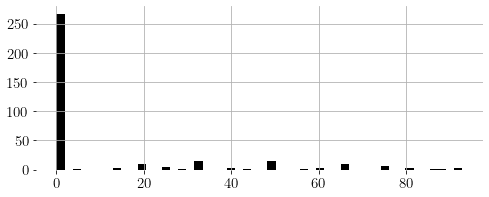

In [13]:
histUnknown(df_all).figure.savefig('images/RQ1Hist.pdf', bbox_inches='tight')

This histogram shows how the accuracy of nodel-level recovery is distributed per node

### The historgram of frequencies of API call unknown percentages per node (for those that are non zero)

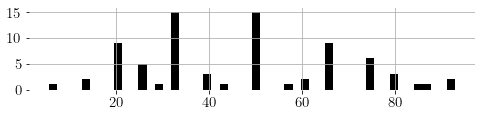

In [14]:
plt.clf()
histUnknownNZ(df_all).figure.savefig('images/RQ1Hist_nz.pdf', bbox_inches='tight')

This histogram shows how the accuracy of nodel-level recovery is distributed per node (for nodes that cannot be fully recoverd)

# RQ2 - How accurately does ROSDiscover statically recover run-time architectures of real ROS systems?

In [15]:
rq2_columnremap = {'# observed':'observed', '# recovered':'recovered', "# obs ! rec":"obs not rec", "# rec ! obs":"rec not obs", "over_approx":"overapprox", "under_approx":"underapprox"}
rq2_headers = ["observed", "recovered", "overapprox", "underapprox"]

In [16]:
def to_percent(d):
    return (d * 100) 
def over_approx(x):
    if x['observed'] == 0:
        return 0
    else:
        return to_percent(x['rec not obs'] / x['observed'])

def under_approx(x):
    if x['observed'] == 0:
        return 0
    else:
        return to_percent(x['obs not rec'] / x['observed'])

In [17]:
def process_df_rq2(df):
    df['overapprox'] = df.apply(lambda x: over_approx(x), axis=1)
    df['underapprox'] = df.apply(lambda x: under_approx(x), axis=1)
    return df


## Reading the Raw Data

In [18]:
df_rq2_all = pd.read_csv(f'data/RQ2 Observed Architecture - Node-Level Comparison.csv')
df_rq2_all = df_rq2_all.fillna(0)
df_rq2_all = df_rq2_all[df_rq2_all["Subject"] != 0].copy()

df_rq2_all.rename(columns = rq2_columnremap, inplace = True)
df_rq2 = df_rq2_all[df_rq2_all["Case"] == "recovered"].groupby(by=["Subject", "Kind"], as_index=False).sum()
df_rq2 = process_df_rq2(df_rq2)
df_rq2

,Subject,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders
0,AutoRally,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,AutoRally,Action Servers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,AutoRally,Providers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,AutoRally,Publishers,6.0,6.0,0.0,0.0,0.000000,0.000000,6.0,8.0,8.0,4.0,0.0
4,AutoRally,Subscribers,7.0,7.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,Husky,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,Husky,Action Servers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,Husky,Providers,4.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8,Husky,Publishers,9.0,8.0,2.0,1.0,11.111111,22.222222,2.0,5.0,8.0,4.0,0.0
9,Husky,Subscribers,6.0,5.0,1.0,0.0,0.000000,16.666667,0.0,0.0,0.0,0.0,0.0


## Statistics on Hand-written models

In [19]:
df_rq2_hw_all = pd.read_csv(f'data/RQ2 Observed Architecture - Comparison.csv')
df_rq2_hw_all = df_rq2_hw_all.fillna(0)
df_rq2_hw_all.rename(columns = rq2_columnremap, inplace = True)
df_rq2_hw_all.pop('# errs observed')
df_rq2_hw_all.pop('# errors recovered')
df_rq2_hw_all.pop('#handwritten')
df_rq2_hw_all.pop('#recovered')
df_rq2_hw_all.pop('# placeholders')

#Select only handwritten models
df_rq2_hw_all = df_rq2_hw_all[df_rq2_hw_all["Subject"] != 0].copy()[df_rq2_hw_all["Case"] == "handwritten"] 
df_rq2_hw = df_rq2_hw_all.groupby(by="Subject", as_index=False).sum()
df_rq2_hw = process_df_rq2(df_rq2_hw)


<ipython-input-19-fb7142558e32>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rq2_hw_all = df_rq2_hw_all[df_rq2_hw_all["Subject"] != 0].copy()[df_rq2_hw_all["Case"] == "handwritten"]


In [20]:
df_rq2_hw_all.groupby(by=["Subject"]).sum()

,observed,recovered,obs not rec,rec not obs,overapprox,underapprox
Subject,,,,,,
AutoRally,99.0,101.0,0.0,2.0,0.070505,0.000000
Husky,64.0,81.0,6.0,23.0,1.423077,0.314103
TurtleBot,76.0,72.0,6.0,2.0,0.109181,0.282878


In [21]:
df_rq2_hw_agg = df_rq2_hw_all.groupby(by=["Kind"], as_index=False).sum()
df_rq2_hw_agg = process_df_rq2(df_rq2_hw_agg)
df_rq2_hw_agg['Subject'] = "All" 
df_rq2_hw_merge = pd.concat([df_rq2_hw, df_rq2_hw_agg.groupby(by=["Subject"], as_index=False).sum()])
#df_rq2_hw_merge = df_rq2_hw_merge.groupby(by=["Subject"], as_index=False).sum()
df_rq2_hw_merge = process_df_rq2(df_rq2_hw_merge)

df_rq2_hw_merge.to_csv('RQ2_handwritten.csv', index = False, columns=["Subject"]+rq2_headers)
df_rq2_hw_kind = df_rq2_hw_agg.drop(df_rq2_hw_agg[df_rq2_hw_agg.Kind == "Nodes"].index) 
df_rq2_hw_kind.to_csv('RQ2_handwritten_architectural_element.csv', index = False, columns=["Kind"]+rq2_headers)

df_rq2_hw_merge

,Subject,observed,recovered,obs not rec,rec not obs,overapprox,underapprox
0,AutoRally,99.0,101.0,0.0,2.0,2.020202,0.000000
1,Husky,64.0,81.0,6.0,23.0,35.937500,9.375000
2,TurtleBot,76.0,72.0,6.0,2.0,2.631579,7.894737
0,All,239.0,254.0,12.0,27.0,11.297071,5.020921


Statistics on the handwritten models

In [22]:
df_rq2_hw_kind

,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,Subject
0,Action Clients,0.0,0.0,0.0,0.0,0.000000,0.000000,All
1,Action Servers,1.0,2.0,0.0,1.0,100.000000,0.000000,All
2,Providers,107.0,110.0,4.0,7.0,6.542056,3.738318,All
3,Publishers,83.0,89.0,5.0,11.0,13.253012,6.024096,All
4,Subscribers,48.0,53.0,3.0,8.0,16.666667,6.250000,All


Statistics on the handwritten models

In [23]:
df_rq2_models = pd.read_csv(f'data/RQ2 Observed Architecture - Models.csv')
df_rq2_models.fillna('',inplace=True)
df_rq2_models = df_rq2_models.drop_duplicates(subset=['Handwritten Node'])
df_rq2_models

,Handwritten Node,Type,Kind,Reason Used
0,spawn_turtlebot_model,spawner,Simulation,Loads robot model
1,gazebo_gui,,Simulation,
2,robot_state_publisher,,Core,Clang parsing issue
3,gazebo,,Simulation,
4,cmd_vel_mux,,Core,Reads interfaces from configuration parameters
5,move_base,,Core,Plugin architecture
6,spawn_platform,spawner,Simulation,Loads Gazebo Plugins
8,autorally_state_publisher,,Simulation,Python
10,autorally_controller,,Simulation,Python
11,ground_truth_republisher,,Simulation,Python


In [24]:
handwritten_models_total = len(df_rq2_models["Handwritten Node"])
handwritten_models_core = len(df_rq2_models[df_rq2_models["Kind"] == "Core"])
handwritten_models_simulation = len(df_rq2_models[df_rq2_models["Kind"] == "Simulation"])
handwritten_models_python = len(df_rq2_models[df_rq2_models["Reason Used"] == "Python"])

## Recovered Models 

### System-level accuracy of the static recovery per architectural element

In [25]:
df_rq2_agg = df_rq2_all.groupby(by=["Kind"], as_index=False).sum()
df_rq2_agg = process_df_rq2(df_rq2_agg)
df_rq2_agg['Subject'] = "All" 
df_rq2_agg.to_csv('RQ2_architectural_elements.csv', index = False, columns=["Kind"] + rq2_headers)
df_rq2_agg

,Kind,observed,recovered,obs not rec,rec not obs,overapprox,underapprox,# errs observed,# errors recovered,#handwritten,#recovered,# placeholders,Subject
0,Action Clients,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,All
1,Action Servers,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,All
2,Providers,8.0,8.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,All
3,Publishers,20.0,20.0,2.0,2.0,10.00,10.0,10.0,15.0,24.0,12.0,0.0,All
4,Subscribers,16.0,15.0,2.0,1.0,6.25,12.5,0.0,0.0,0.0,0.0,0.0,All


Accuracy of static recovery (for AutoRally, Husky, and TurtleBot) per architectural element

In [26]:
df_rq2_merge = pd.concat([df_rq2, df_rq2_agg])
df_rq2_merge = df_rq2_merge.groupby(by=["Subject"], as_index=False).sum()
df_rq2_merge = process_df_rq2(df_rq2_merge)
df_rq2_merge.to_csv('RQ2All.csv', index = False)

In [27]:
rq2_subjects = list(set(df_rq2["Subject"]))
rq2_subjects.sort()
rq2_subjects_ = rq2_subjects+["All"]

### System-level accuracy of the static recovery

In [28]:
df_rq_all = df_rq2_merge.groupby(by="Subject").sum()
df_rq_all['overapprox'] = df_rq_all.apply(lambda x: over_approx(x), axis=1)
df_rq_all['underapprox'] = df_rq_all.apply(lambda x: under_approx(x), axis=1)
df_rq_all = df_rq_all.reindex(rq2_subjects+["All"])
df_rq_all.to_csv('RQ2.csv', index = True, columns=rq2_headers )
df_rq_all

PermissionError: [Errno 13] Permission denied: 'RQ2.csv'

Accuracy of static recovery per system. Observed and recovered contains publishers, subscribers, service providers, and  action servers. Our systems do not use action clients. "All" contains all configurations, with reused nodes showing up multiple times

In [ ]:
print(f"Total handwritten models in experiments: {handwritten_models_total}")
print(f"Total handwritten models in core library: {handwritten_models_core}")
print(f"Total handwritten models for simulation nodes:{handwritten_models_simulation}")
print(f"Total handwritten models for Python nodes: {handwritten_models_python}")

for name in rq2_subjects_:
    overapprox = df_rq_all["overapprox"].iloc[df_rq_all.index == name][name]
    print(f"{name} overapproximation: {overapprox:.3f}")
    underapprox = df_rq_all["underapprox"].iloc[df_rq_all.index == name][name]
    print(f"{name} underapproximation: {underapprox:.3f}")
    handwritten = df_rq_all["#handwritten"].iloc[df_rq_all.index == name][name]
    print(f"Handwritten models for {name}: {int(handwritten)}")
    recovered = df_rq_all["#recovered"].iloc[df_rq_all.index == name][name]
    print(f"Recovered models for {name}: {int(handwritten)}")
    if (name != "All"):
        false_positives = df_rq2_all[df_rq2_all["Subject"] == name]["# errors recovered"].max()    
        print(f"False positives for {name}: {int(false_positives)}")
    
for name in set(df_rq2_agg["Kind"]):
    name_ = name.replace(" ", "")
    overapprox = list(df_rq2_agg[df_rq2_agg["Kind"] == name]["overapprox"])[0]
    print(f"{name} overapproximation: {overapprox:.3f}")
    underapprox = list(df_rq2_agg[df_rq2_agg["Kind"] == name]["underapprox"])[0]
    print(f"{name} underapproximation: {underapprox:.3f}")


# RQ3 - How effectively does ROSDiscover find configuration bugs in real ROS systems?

In [ ]:
df_rq3 = pd.read_csv(f'data/RosTopicBugs - RQ3 - Results Table.csv').drop(columns=["Github commit message", "Reason for non recovery", "Issue"])
df_rq3.fillna('',inplace=True)
df_rq3 = df_rq3.sort_values(by=['Description','Bug'])
df_rq3

In [ ]:
rq3_numBugs = len(df_rq3)
print(f"Number of bugs: {rq3_numBugs}")

detectInVivo = df_rq3["in-vivo"].value_counts()["x"]
print(f"Bugs detected in-vivo: {detectInVivo}")

detectInVitro = df_rq3["in-vitro"].value_counts()["x"]
print(f"Bugs detected using forward- bugs: {detectInVitro}")

detectInVitro = df_rq3["in-vitro"].value_counts()["x"]
numDetected = detectInVivo + detectInVitro
print(f"Bugs detected in total: {numDetected}")

detectInTheory = df_rq3["in-theory"].value_counts()["x"]
print(f"Bugs detectable in theory: {detectInTheory}")

undetectable = len(df_rq3) - detectInVivo - detectInVitro - detectInTheory
print(f"Undetectable bugs: {undetectable}")
    
precision_percent = (numDetected) / rq3_numBugs * 100
print(f"Precision: {round(precision_percent)}%")

precision_incl_theory_percent = (numDetected  + detectInTheory) / rq3_numBugs * 100
print(f"Precision incl. in-theory: {round(precision_incl_theory_percent)}%")

In [ ]:
def bug_link(x):
    bug_id = x["Bug"]
    bug_link = x["Link"]
    result = "\href{"+bug_link+"}{"+bug_id+"}"
    if x["in-vitro"] == "x":
        result = result+" *"
    return result

In [ ]:
def detectable(x):
    if x["in-vitro"] == "x" or x["in-vivo"] =="x":
            return "\checkmark"
    else:
            return ""

In [ ]:
df_rq3_latex = df_rq3.copy()
df_rq3_latex['detected'] = df_rq3_latex.apply(lambda x: detectable(x), axis=1)
df_rq3_latex['Bug'] = df_rq3_latex.apply(lambda x: bug_link(x), axis=1)
df_rq3_latex = df_rq3_latex.replace("x", "\checkmark")
df_rq3_latex.to_csv('RQ3.csv', index = False, columns=["Bug", "detected", "in-theory", "Description"])
df_rq3_latex